<a href="https://colab.research.google.com/github/Ehsan-Roohi/Cavity/blob/main/Supervised_Learning_Cavity_Re%3D100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ======================================================
# Lid-Driven Cavity Solver for Re=7000
# HIGH-FIDELITY VERSION with Hybrid Scheme and Fine Mesh to capture Tertiary Vortices
# ======================================================

import numpy as np
import time
import os
import matplotlib.pyplot as plt

# Try to import CuPy and handle various GPU-related errors
GPU_AVAILABLE = False
try:
    import cupy as cp
    GPU_AVAILABLE = True
    print("CuPy successfully imported. GPU acceleration is available.")
except ImportError:
    print("CuPy not found. Falling back to CPU computation with NumPy.")
except Exception as e:
    print(f"GPU error detected: {e}")
    print("Falling back to CPU computation with NumPy.")

# Use NumPy as fallback when GPU is not available
if GPU_AVAILABLE:
    xp = cp
    device_name = "GPU"
else:
    xp = np
    device_name = "CPU"

def solve_lid_driven_cavity_high_fidelity():
    """
    Solves the 2D Lid-Driven Cavity at Re=7000 using a high-resolution grid
    and a hybrid discretization scheme to capture weak tertiary vortices.
    """
    # --- 1. High-Fidelity Parameters ---
    nx = 256  # Increased resolution is critical for capturing small vortices
    ny = 256
    max_physical_time = 250.0 # Longer simulation time for flow to fully develop
    nit_pressure = 100      # More pressure iterations for accuracy

    Lx = 1.0
    Ly = 1.0
    dx = Lx / (nx - 1)
    dy = Ly / (ny - 1)

    # Physical Properties & Timestepping
    Re = 7000.0
    nu = 1.0 / Re
    sigma = 0.1 # A small CFL number for stability
    dt = sigma * min(dx, dy)

    print(f"{device_name}-Accelerated on Grid: {nx}x{ny}, Re: {Re}, Stable dt: {dt:.8f}")
    print(f"Simulation will run until t = {max_physical_time}")

    # --- 2. Initialize Fields ---
    u = xp.zeros((ny, nx), dtype=xp.float64)
    v = xp.zeros((ny, nx), dtype=xp.float64)
    p = xp.zeros((ny, nx), dtype=xp.float64)

    # --- 3. Main Solver Loop ---
    print(f"Running simulation on {device_name} (this will take a considerable amount of time)...")
    start_loop_time = time.time()

    t = 0
    step_count = 0
    print_interval = max(1, int(10.0 / dt)) # Print progress every 10 time units

    simulation_stable = True
    while t < max_physical_time:
        un = u.copy()
        vn = v.copy()
        u_star = u.copy()
        v_star = v.copy()

        # --- Predictor step with a Hybrid (Blended) Scheme ---
        # gamma=1.0 -> Fully Upwind, gamma=0.0 -> Fully Central Difference
        gamma = 0.1 # Blend factor: 90% Central, 10% Upwind

        # -- U-Momentum --
        # Central difference terms
        u_conv_cd = un[1:-1, 1:-1] * (un[1:-1, 2:] - un[1:-1, 0:-2]) / (2*dx)
        v_conv_cd = vn[1:-1, 1:-1] * (un[2:, 1:-1] - un[0:-2, 1:-1]) / (2*dy)

        # Upwind terms
        u_conv_uw = un[1:-1, 1:-1] * xp.where(un[1:-1, 1:-1] > 0, (un[1:-1, 1:-1] - un[1:-1, 0:-2]) / dx, (un[1:-1, 2:] - un[1:-1, 1:-1]) / dx)
        v_conv_uw = vn[1:-1, 1:-1] * xp.where(vn[1:-1, 1:-1] > 0, (un[1:-1, 1:-1] - un[0:-2, 1:-1]) / dy, (un[2:, 1:-1] - un[1:-1, 1:-1]) / dy)

        # Blended convection term for u
        conv_u = gamma * (u_conv_uw + v_conv_uw) + (1 - gamma) * (u_conv_cd + v_conv_cd)

        # Diffusion term for u
        diff_u = nu * ((un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, 0:-2]) / dx**2 + (un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[0:-2, 1:-1]) / dy**2)

        u_star[1:-1, 1:-1] = un[1:-1, 1:-1] + dt * (-conv_u + diff_u)

        # -- V-Momentum (similar hybrid scheme) --
        u_conv_cd_v = un[1:-1, 1:-1] * (vn[1:-1, 2:] - vn[1:-1, 0:-2]) / (2*dx)
        v_conv_cd_v = vn[1:-1, 1:-1] * (vn[2:, 1:-1] - vn[0:-2, 1:-1]) / (2*dy)

        u_conv_uw_v = un[1:-1, 1:-1] * xp.where(un[1:-1, 1:-1] > 0, (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) / dx, (vn[1:-1, 2:] - vn[1:-1, 1:-1]) / dx)
        v_conv_uw_v = vn[1:-1, 1:-1] * xp.where(vn[1:-1, 1:-1] > 0, (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) / dy, (vn[2:, 1:-1] - vn[1:-1, 1:-1]) / dy)

        conv_v = gamma * (u_conv_uw_v + v_conv_uw_v) + (1 - gamma) * (u_conv_cd_v + v_conv_cd_v)

        diff_v = nu * ((vn[1:-1, 2:] - 2*vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) / dx**2 + (vn[2:, 1:-1] - 2*vn[1:-1, 1:-1] + vn[0:-2, 1:-1]) / dy**2)

        v_star[1:-1, 1:-1] = vn[1:-1, 1:-1] + dt * (-conv_v + diff_v)

        # --- Pressure-Poisson and Corrector steps ---
        div_star = ((u_star[1:-1, 2:] - u_star[1:-1, :-2]) / (2*dx) + (v_star[2:, 1:-1] - v_star[:-2, 1:-1]) / (2*dy))
        rhs_p = (1.0 / dt) * div_star

        for _ in range(nit_pressure):
            pn = p.copy()
            p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, :-2]) * dy**2 + (pn[2:, 1:-1] + pn[:-2, 1:-1]) * dx**2 - rhs_p * dx**2 * dy**2) / (2 * (dx**2 + dy**2)))
            p[:, -1] = p[:, -2]; p[0, :] = p[1, :]; p[:, 0] = p[:, 1]; p[-1, :] = p[-2, :]

        u[1:-1, 1:-1] = u_star[1:-1, 1:-1] - (dt/1.0) * (p[1:-1, 2:] - p[1:-1, :-2]) / (2 * dx)
        v[1:-1, 1:-1] = v_star[1:-1, 1:-1] - (dt/1.0) * (p[2:, 1:-1] - p[:-2, 1:-1]) / (2 * dy)

        # --- Enforce boundary conditions ---
        u[0, :] = 0; u[:, 0] = 0; u[:, -1] = 0; u[-1, :] = 1.0
        v[0, :] = 0; v[-1, :] = 0; v[:, 0] = 0; v[:, -1] = 0

        t += dt; step_count += 1

        if step_count % print_interval == 0:
            print(f"Time: {t:.2f}/{max_physical_time:.1f} - Progress: {100*t/max_physical_time:.1f}%")

    end_loop_time = time.time()
    print(f"\n✅ Simulation completed in {end_loop_time - start_loop_time:.2f} seconds.")
    return u, v, p, True, nx, ny

def plot_comprehensive_results(u_final, v_final, p_final, Re, device_name, nx, ny):
    # This is the same comprehensive plotting function from before
    print("\nGenerating comprehensive plots...")
    output_dir = "results_high_fidelity"
    if not os.path.exists(output_dir): os.makedirs(output_dir)

    if GPU_AVAILABLE:
        u_cpu, v_cpu, p_cpu = u_final.get(), v_final.get(), p_final.get()
    else:
        u_cpu, v_cpu, p_cpu = u_final, v_final, p_final

    x = np.linspace(0, 1.0, nx); y = np.linspace(0, 1.0, ny)
    X, Y = np.meshgrid(x, y); speed = np.sqrt(u_cpu**2 + v_cpu**2)

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle(f'High-Fidelity Lid-Driven Cavity at Re={Re} ({device_name})', fontsize=18)

    # Main Velocity Field
    ax1 = axes[0, 0]; cf1 = ax1.contourf(X, Y, speed, levels=50, cmap='coolwarm'); fig.colorbar(cf1, ax=ax1, label='Velocity Magnitude (m/s)'); ax1.streamplot(X, Y, u_cpu, v_cpu, color='black', linewidth=0.6, density=2.0); ax1.set_title('Overall Velocity Field'); ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_aspect('equal')
    # Pressure Field
    ax2 = axes[0, 1]; cf2 = ax2.contourf(X, Y, p_cpu, levels=50, cmap='jet'); fig.colorbar(cf2, ax=ax2, label='Pressure'); ax2.set_title('Pressure Field'); ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_aspect('equal')
    # Zoom-in on Bottom-Left Corner
    ax3 = axes[1, 0]; ax3.contourf(X, Y, speed, levels=50, cmap='coolwarm', alpha=0.7); ax3.streamplot(X, Y, u_cpu, v_cpu, color='black', linewidth=0.8, density=3.0); ax3.set_title('Zoom: Bottom-Left Corner'); ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_xlim(0, 0.15); ax3.set_ylim(0, 0.15); ax3.set_aspect('equal')
    # Zoom-in on Top-Left Corner (for the tertiary vortex)
    ax4 = axes[1, 1]; ax4.contourf(X, Y, speed, levels=50, cmap='coolwarm', alpha=0.7); ax4.streamplot(X, Y, u_cpu, v_cpu, color='black', linewidth=0.8, density=3.0); ax4.set_title('Zoom: Top-Left Corner'); ax4.set_xlabel('x'); ax4.set_ylabel('y'); ax4.set_xlim(0, 0.15); ax4.set_ylim(0.85, 1.0); ax4.set_aspect('equal')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    filename1 = os.path.join(output_dir, f'cavity_Re{Re}_field_plots.png'); plt.savefig(filename1, dpi=300)
    plt.close(fig)
    print(f"Saved field plots to '{filename1}'")

# --- Main Execution Block ---
if __name__ == "__main__":
    results = solve_lid_driven_cavity_high_fidelity()
    if results[3]:
        plot_comprehensive_results(u_final=results[0], v_final=results[1], p_final=results[2],
                                   Re=7000, device_name=device_name,
                                   nx=results[4], ny=results[5])

CuPy successfully imported. GPU acceleration is available.
GPU-Accelerated on Grid: 256x256, Re: 7000.0, Stable dt: 0.00039216
Simulation will run until t = 250.0
Running simulation on GPU (this will take a considerable amount of time)...
Time: 10.00/250.0 - Progress: 4.0%
Time: 20.00/250.0 - Progress: 8.0%
Time: 30.00/250.0 - Progress: 12.0%
Time: 40.00/250.0 - Progress: 16.0%
Time: 50.00/250.0 - Progress: 20.0%
Time: 60.00/250.0 - Progress: 24.0%
Time: 70.00/250.0 - Progress: 28.0%
Time: 80.00/250.0 - Progress: 32.0%
Time: 90.00/250.0 - Progress: 36.0%
Time: 100.00/250.0 - Progress: 40.0%
Time: 110.00/250.0 - Progress: 44.0%
Time: 120.00/250.0 - Progress: 48.0%
Time: 129.99/250.0 - Progress: 52.0%
Time: 139.99/250.0 - Progress: 56.0%


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# ==============================================================================
# بخش ۱: حل‌گر دینامیک سیالات محاسباتی (CFD)
# این بخش کد CFD است که برای تولید داده‌های آموزشی استفاده می‌شود.
# ==============================================================================
def solve_cfd_cavity(nx=81, ny=81, Re=100.0, max_physical_time=15.0):
    """
    Solves the 2D Lid-Driven Cavity problem using a Finite Difference Method.
    Returns velocity (u, v), pressure p and coordinates X, Y.
    """
    print("--- مرحله ۱: شروع حل با استفاده از کد CFD ---")
    # پارامترهای شبکه
    Lx, Ly = 1.0, 1.0
    dx, dy = Lx/(nx-1), Ly/(ny-1)
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X, Y = np.meshgrid(x, y)
    nu = 1.0/Re
    sigma = 0.2
    dt = sigma * min(dx**2/nu, dy**2/nu)
    print(f"CFD Grid: {nx}x{ny}, Re: {Re}, Stable dt: {dt:.6f}")
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))

    t, step = 0.0, 0
    start_time = time.time()
    nit = 50
    while t < max_physical_time:
        un, vn = u.copy(), v.copy()
        # معادلات حرکت
        u[1:-1,1:-1] = (un[1:-1,1:-1] - dt/dx * un[1:-1,1:-1] * (un[1:-1,1:-1]-un[1:-1,0:-2])
                         - dt/dy * vn[1:-1,1:-1] * (un[1:-1,1:-1]-un[0:-2,1:-1])
                         - dt/(2*dx) * (p[1:-1,2:] - p[1:-1,0:-2])
                         + nu*dt/dx**2*(un[1:-1,2:] - 2*un[1:-1,1:-1] + un[1:-1,0:-2])
                         + nu*dt/dy**2*(un[2:,1:-1] - 2*un[1:-1,1:-1] + un[0:-2,1:-1]))
        v[1:-1,1:-1] = (vn[1:-1,1:-1] - dt/dx * un[1:-1,1:-1] * (vn[1:-1,1:-1]-vn[1:-1,0:-2])
                         - dt/dy * vn[1:-1,1:-1] * (vn[1:-1,1:-1]-vn[0:-2,1:-1])
                         - dt/(2*dy) * (p[2:,1:-1] - p[0:-2,1:-1])
                         + nu*dt/dx**2*(vn[1:-1,2:] - 2*vn[1:-1,1:-1] + vn[1:-1,0:-2])
                         + nu*dt/dy**2*(vn[2:,1:-1] - 2*vn[1:-1,1:-1] + vn[0:-2,1:-1]))
        # شرایط مرزی
        u[0,:] = u[:,0] = u[:,-1] = 0.0
        u[-1,:] = 1.0
        v[0,:] = v[-1,:] = v[:,0] = v[:,-1] = 0.0
        # فشار Poisson
        rhs_p = (1/dt*((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx) + (v[2:,1:-1]-v[0:-2,1:-1])/(2*dy)))
        for _ in range(nit):
            pn = p.copy()
            p[1:-1,1:-1] = (((pn[1:-1,2:] + pn[1:-1,0:-2]) * dy**2 +
                              (pn[2:,1:-1] + pn[0:-2,1:-1]) * dx**2 -
                              rhs_p * dx**2 * dy**2) /
                             (2*(dx**2 + dy**2)))
            p[:, -1] = p[:, -2]
            p[0, :] = p[1, :]
            p[:, 0] = p[:, 1]
            p[-1, :] = 0.0
        t += dt
        step += 1
    print(f"حل CFD در {time.time() - start_time:.2f} ثانیه به پایان رسید.")
    return u, v, p, X, Y

# ==============================================================================
# بخش ۲: شبکه عصبی و یادگیری نظارت‌شده (float32)
# ==============================================================================
class SupervisedCavityModel:
    def __init__(self, layers=[2,64,64,64,64,64,3], lr=1e-3):
        self.layers = layers
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    def build_model(self):
        inputs = Input(shape=(self.layers[0],), dtype='float32')
        x = inputs
        for units in self.layers[1:-1]:
            x = Dense(units, activation='tanh')(x)
        outputs = Dense(self.layers[-1], name='outputs')(x)
        return Model(inputs=inputs, outputs=outputs)

    def prepare_training_data(self, u, v, p, X, Y):
        # Flatten arrays and cast to float32
        X_flat = X.flatten(); Y_flat = Y.flatten()
        u_flat = u.flatten(); v_flat = v.flatten(); p_flat = p.flatten()
        inputs = np.vstack([X_flat, Y_flat]).T.astype(np.float32)
        outputs = np.vstack([u_flat, v_flat, p_flat]).T.astype(np.float32)
        return tf.constant(inputs), tf.constant(outputs)

    def train(self, cfd_data, n_epochs=10000, batch_size=2048):
        print("\n--- مرحله ۲: شروع آموزش شبکه عصبی با داده‌های CFD ---")
        X_train, y_train = self.prepare_training_data(*cfd_data)
        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        dataset = dataset.shuffle(len(X_train)).batch(batch_size)
        start = time.time()
        for epoch in range(n_epochs):
            for x_batch, y_batch in dataset:
                with tf.GradientTape() as tape:
                    y_pred = self.model(x_batch, training=True)
                    loss = tf.reduce_mean(tf.square(y_pred - y_batch))
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            if (epoch+1) % 1000 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.numpy():.4e}")
        print(f"آموزش شبکه در {time.time() - start:.2f} ثانیه به پایان رسید.")

    def plot_comparison(self, cfd_data):
        print("\n--- مرحله ۳: مقایسه نتایج CFD و شبکه عصبی ---")
        u_cfd, v_cfd, p_cfd, X, Y = cfd_data
        pts = np.hstack([X.flatten()[:,None], Y.flatten()[:,None]]).astype(np.float32)
        preds = self.model.predict(pts)
        u_nn = preds[:,0].reshape(X.shape)
        v_nn = preds[:,1].reshape(X.shape)
        p_nn = preds[:,2].reshape(X.shape)
        # Plotting
        fig, axes = plt.subplots(2,3, figsize=(18,10))
        fig.suptitle('CFD (top) vs NN (bottom)', fontsize=16)
        speed_cfd = np.sqrt(u_cfd**2 + v_cfd**2)
        speed_nn  = np.sqrt(u_nn**2  + v_nn**2)
        axes[0,0].contourf(X,Y, speed_cfd, levels=50, cmap='plasma'); axes[0,0].set_title('CFD Speed')
        axes[0,1].contourf(X,Y, p_cfd, levels=50, cmap='viridis');    axes[0,1].set_title('CFD Pressure')
        axes[0,2].streamplot(X,Y,u_cfd,v_cfd, density=1.5, color='k', linewidth=0.8); axes[0,2].set_title('CFD Streamlines')
        axes[1,0].contourf(X,Y, speed_nn,  levels=50, cmap='plasma'); axes[1,0].set_title('NN Speed')
        axes[1,1].contourf(X,Y, p_nn,   levels=50, cmap='viridis');    axes[1,1].set_title('NN Pressure')
        axes[1,2].streamplot(X,Y,u_nn,v_nn, density=1.5, color='k', linewidth=0.8); axes[1,2].set_title('NN Streamlines')
        for ax in axes.flatten():
            ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_aspect('equal')
        plt.tight_layout(rect=[0,0,1,0.96])
        plt.show()

# ==============================================================================
# بخش ۳: اجرای اصلی
# ==============================================================================
if __name__ == '__main__':
    cfd_results = solve_cfd_cavity(nx=81, ny=81, Re=100.0)
    model = SupervisedCavityModel()
    model.train(cfd_data=cfd_results, n_epochs=15000)
    model.plot_comparison(cfd_data=cfd_results)


--- مرحله ۱: شروع حل با استفاده از کد CFD ---
CFD Grid: 81x81, Re: 100.0, Stable dt: 0.003125
حل CFD در 12.61 ثانیه به پایان رسید.

--- مرحله ۲: شروع آموزش شبکه عصبی با داده‌های CFD ---
Epoch 1000/15000, Loss: 7.0032e-04
Epoch 2000/15000, Loss: 1.6750e-04
Epoch 3000/15000, Loss: 1.5973e-04
Epoch 4000/15000, Loss: 1.9810e-04
Epoch 5000/15000, Loss: 1.0324e-04


KeyboardInterrupt: 

In [ ]:
# Step 1: Install specific compatible library versions
# This is crucial to prevent version conflicts in Google Colab.
!pip install tensorflow==2.15.0
!pip install keras==2.15.0
!pip install tensorflow-probability==0.23.0

# IMPORTANT: After this cell runs, you MUST restart the runtime.
# Go to the menu and select "Runtime" -> "Restart session"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully unins

# Step 4: The Physics-Informed Neural Network Factory (Corrected)

def function_factory(model, train_x, train_lid, Re, nepochs):
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)
    x_domain = tf.Variable([train_x[:,0]], dtype=tf.float64)
    z_domain = tf.Variable([train_x[:,1]], dtype=tf.float64)
    x_lid = tf.Variable([train_lid[:,0]], dtype=tf.float64)
    z_lid = tf.Variable([train_lid[:,1]], dtype=tf.float64)
    
    count = 0
    idx = []
    part = []
    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n
    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    @tf.function
    def f(params_1d):
        with tf.GradientTape(persistent=True) as tape:
            assign_new_model_parameters(params_1d)
            train_x_tensor = tf.transpose(tf.concat([x_domain, z_domain], 0))
            outputs = model(train_x_tensor)
            bcv = 16 * x_domain * (1 - x_domain) * z_domain * (1 - z_domain)
            stream = bcv * bcv * outputs[:,0]
            stream = tf.reshape(stream, (1,-1))
            u = tape.gradient(stream, z_domain)
            stream_x = tape.gradient(stream, x_domain)
            w = -1 * stream_x
            vort = -1 * (tape.gradient(u, z_domain) + tape.gradient(stream_x, x_domain))
            u_vort_dx = tape.gradient(u * vort, x_domain)
            w_vort_dz = tape.gradient(w * vort, z_domain)
            vort_x = tape.gradient(vort, x_domain)
            vort_z = tape.gradient(vort, z_domain)
            vort_xx = tape.gradient(vort_x, x_domain)
            vort_zz = tape.gradient(vort_z, z_domain)
            loss_pde = u_vort_dx + w_vort_dz - (1.0 / Re) * (vort_xx + vort_zz)
            
            train_lid_tensor = tf.transpose(tf.concat([x_lid, z_lid], 0))
            outputs_lid = model(train_lid_tensor)
            bcv_lid = 16 * x_lid * (1 - x_lid) * z_lid * (1 - z_lid)
            stream_lid = bcv_lid * bcv_lid * outputs_lid[:,0]
            stream_lid = tf.reshape(stream_lid, (1,-1))
            u_lid = tape.gradient(stream_lid, z_lid)
            lid_velocity_loss = tf.reduce_mean(tf.square(u_lid - 1.0))
            
            pde_loss = tf.reduce_mean(tf.square(loss_pde))
            loss_value = pde_loss + lid_velocity_loss
            output_loss_vec_tensor = tf.concat(([pde_loss], [lid_velocity_loss]), axis=0)
            
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)
        f.iter.assign_add(1)
        if f.iter % 1000 == 0:
            tf.print("Epoch:", f.iter,"/",nepochs,"\tLoss:", loss_value)
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])
        tf.py_function(f.hist_list.append, inp=[output_loss_vec_tensor], Tout=[])
        del tape
        return loss_value, grads

    f.iter = tf.Variable(0, dtype=tf.int64)
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []
    f.hist_list = []
    f.idx = idx  # Attach idx to the function object
    f.part = part
    f.shapes = shapes
    
    return f

--- مرحله ۱: شروع حل با استفاده از کد CFD (شبکه دقیق‌تر) ---
CFD Grid: 129x129, Re: 100.0, Stable dt: 0.001221
حل CFD در 134.57 ثانیه به پایان رسید.

--- مرحله ۲: شروع آموزش شبکه عصبی با داده‌های CFD ---
آماده‌سازی داده‌های آموزشی با نمونه‌برداری متمرکز در گوشه‌ها...
درون‌یابی داده‌ها برای نقاط متمرکز...
مجموع نقاط آموزشی: 32641
Epoch 1000/15000, Avg Loss: 1.2757e-04
Epoch 2000/15000, Avg Loss: 4.0863e-05
Epoch 3000/15000, Avg Loss: 1.2936e-05
Epoch 4000/15000, Avg Loss: 8.0444e-05
Epoch 5000/15000, Avg Loss: 9.3534e-06

--- مرحله میانی: رایت کردن نتایج در گام 5000 ---
نمودار میانی در مسیر 'intermediate_plots/comparison_epoch_05000.png' ذخیره شد.
Epoch 6000/15000, Avg Loss: 8.4533e-06
Epoch 7000/15000, Avg Loss: 3.5402e-06
Epoch 8000/15000, Avg Loss: 2.3405e-06
Epoch 9000/15000, Avg Loss: 1.3365e-04
Epoch 10000/15000, Avg Loss: 4.8879e-06

--- مرحله میانی: رایت کردن نتایج در گام 10000 ---
نمودار میانی در مسیر 'intermediate_plots/comparison_epoch_10000.png' ذخیره شد.
Epoch 11000/15000, 

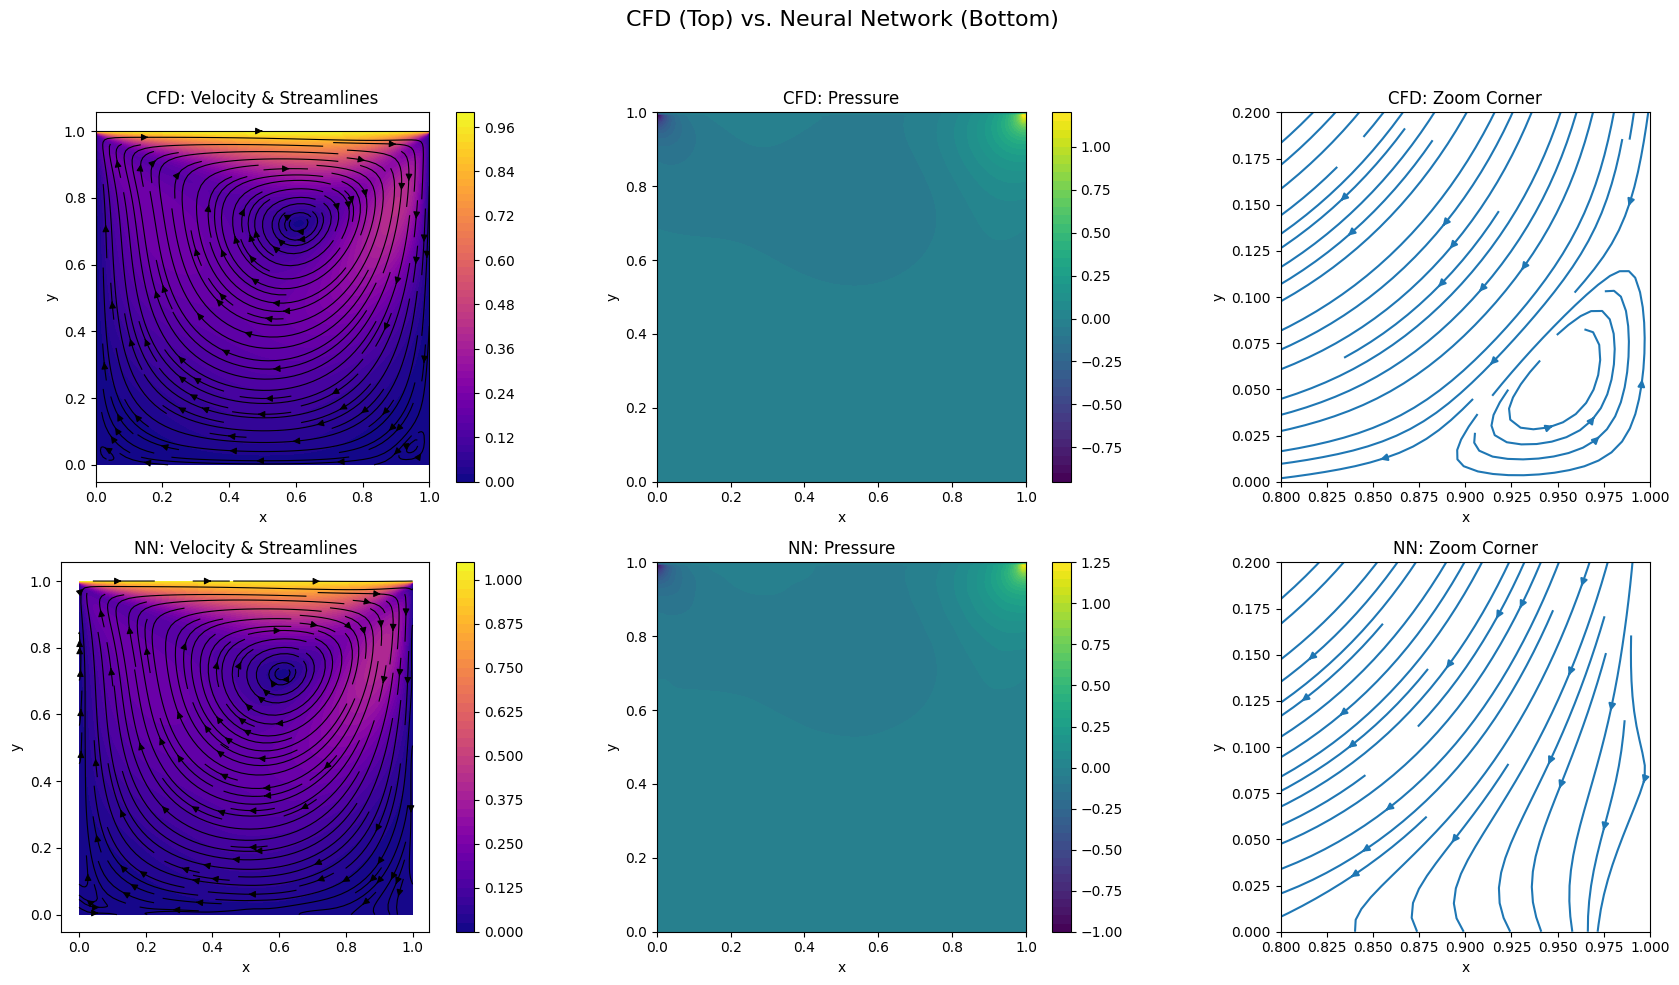

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from scipy.interpolate import griddata

# ==============================================================================
# بخش ۱: حل‌گر دینامیک سیالات محاسباتی (CFD)
# FIX: افزایش دقت شبکه برای تولید داده‌های آموزشی با کیفیت بالاتر
# ==============================================================================
def solve_cfd_cavity(nx=129, ny=129, Re=100.0, max_physical_time=20.0):
    """
    Solves the 2D Lid-Driven Cavity problem on a refined mesh to better
    resolve secondary vortices in the corners.
    """
    print("--- مرحله ۱: شروع حل با استفاده از کد CFD (شبکه دقیق‌تر) ---")
    Lx, Ly = 1.0, 1.0
    dx, dy = Lx/(nx-1), Ly/(ny-1)
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X, Y = np.meshgrid(x, y)
    nu = 1.0/Re
    sigma = 0.2
    dt = sigma * min(dx**2/nu, dy**2/nu)
    print(f"CFD Grid: {nx}x{ny}, Re: {Re}, Stable dt: {dt:.6f}")
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))

    t, step = 0.0, 0
    start_time = time.time()
    nit = 50
    while t < max_physical_time:
        un, vn = u.copy(), v.copy()
        u[1:-1,1:-1] = (un[1:-1,1:-1] - dt/dx * un[1:-1,1:-1] * (un[1:-1,1:-1]-un[1:-1,0:-2])
                         - dt/dy * vn[1:-1,1:-1] * (un[1:-1,1:-1]-un[0:-2,1:-1])
                         - dt/(2*dx) * (p[1:-1,2:] - p[1:-1,0:-2])
                         + nu*dt/dx**2*(un[1:-1,2:] - 2*un[1:-1,1:-1] + un[1:-1,0:-2])
                         + nu*dt/dy**2*(un[2:,1:-1] - 2*un[1:-1,1:-1] + un[0:-2,1:-1]))
        v[1:-1,1:-1] = (vn[1:-1,1:-1] - dt/dx * un[1:-1,1:-1] * (vn[1:-1,1:-1]-vn[1:-1,0:-2])
                         - dt/dy * vn[1:-1,1:-1] * (vn[1:-1,1:-1]-vn[0:-2,1:-1])
                         - dt/(2*dy) * (p[2:,1:-1] - p[0:-2,1:-1])
                         + nu*dt/dx**2*(vn[1:-1,2:] - 2*vn[1:-1,1:-1] + vn[1:-1,0:-2])
                         + nu*dt/dy**2*(vn[2:,1:-1] - 2*vn[1:-1,1:-1] + vn[0:-2,1:-1]))
        u[0,:] = u[:,0] = u[:,-1] = 0.0
        u[-1,:] = 1.0
        v[0,:] = v[-1,:] = v[:,0] = v[:,-1] = 0.0
        rhs_p = (1/dt*((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx) + (v[2:,1:-1]-v[0:-2,1:-1])/(2*dy)))
        for _ in range(nit):
            pn = p.copy()
            p[1:-1,1:-1] = (((pn[1:-1,2:] + pn[1:-1,0:-2]) * dy**2 +
                                 (pn[2:,1:-1] + pn[0:-2,1:-1]) * dx**2 -
                                 rhs_p * dx**2 * dy**2) /
                                (2*(dx**2 + dy**2)))
            p[:, -1] = p[:, -2]
            p[0, :] = p[1, :]
            p[:, 0] = p[:, 1]
            p[-1, :] = 0.0
        t += dt
        step += 1
    print(f"حل CFD در {time.time() - start_time:.2f} ثانیه به پایان رسید.")
    return u, v, p, X, Y

# ==============================================================================
# بخش ۲: شبکه عصبی و یادگیری نظارت‌شده (float32)
# ==============================================================================
class SupervisedCavityModel:
    def __init__(self, layers=[2,64,64,64,64,64,3], lr=1e-3):
        self.layers = layers
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    def build_model(self):
        inputs = Input(shape=(self.layers[0],), dtype='float32')
        x = inputs
        for units in self.layers[1:-1]:
            x = Dense(units, activation='tanh')(x)
        outputs = Dense(self.layers[-1], name='outputs')(x)
        return Model(inputs=inputs, outputs=outputs)

    def prepare_training_data(self, u, v, p, X, Y):
        """
        FIX: Implements a focused importance sampling by adding a high density
        of points specifically in the bottom corners to help the NN learn the
        secondary vortices.
        """
        print("آماده‌سازی داده‌های آموزشی با نمونه‌برداری متمرکز در گوشه‌ها...")

        # داده‌های اصلی از شبکه CFD
        X_flat = X.flatten(); Y_flat = Y.flatten()
        u_flat = u.flatten(); v_flat = v.flatten(); p_flat = p.flatten()
        cfd_inputs = np.vstack([X_flat, Y_flat]).T
        cfd_outputs = np.vstack([u_flat, v_flat, p_flat]).T

        # --- ایجاد نقاط اضافی با تراکم بالا در گوشه‌های پایینی ---
        n_corners = 8000  # تعداد نقاط اضافی برای هر گوشه
        corner_size = 0.2 # اندازه ناحیه گوشه

        # گوشه پایین-چپ
        corner_x_bl = np.random.rand(n_corners, 1) * corner_size
        corner_y_bl = np.random.rand(n_corners, 1) * corner_size

        # گوشه پایین-راست
        corner_x_br = 1.0 - (np.random.rand(n_corners, 1) * corner_size)
        corner_y_br = np.random.rand(n_corners, 1) * corner_size

        # ترکیب نقاط گوشه‌ها
        biased_inputs_np = np.vstack([
            np.hstack([corner_x_bl, corner_y_bl]),
            np.hstack([corner_x_br, corner_y_br])
        ])

        # درون‌یابی برای یافتن مقادیر u,v,p در نقاط جدید
        print("درون‌یابی داده‌ها برای نقاط متمرکز...")
        biased_outputs_np = griddata(cfd_inputs, cfd_outputs, biased_inputs_np, method='cubic')

        # ترکیب داده‌های اصلی و بایاس شده
        final_inputs = np.concatenate([cfd_inputs, biased_inputs_np]).astype(np.float32)
        final_outputs = np.concatenate([cfd_outputs, biased_outputs_np]).astype(np.float32)

        print(f"مجموع نقاط آموزشی: {len(final_inputs)}")
        return tf.constant(final_inputs), tf.constant(final_outputs)

    def train(self, cfd_data, n_epochs=15000, batch_size=4096, plot_freq=5000):
        print("\n--- مرحله ۲: شروع آموزش شبکه عصبی با داده‌های CFD ---")
        X_train, y_train = self.prepare_training_data(*cfd_data)
        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size)

        start = time.time()

        if not os.path.exists('intermediate_plots'):
            os.makedirs('intermediate_plots')

        for epoch in range(n_epochs):
            epoch_loss = 0
            for step, (x_batch, y_batch) in enumerate(dataset):
                with tf.GradientTape() as tape:
                    y_pred = self.model(x_batch, training=True)
                    loss = tf.reduce_mean(tf.square(y_pred - y_batch))
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
                epoch_loss += loss

            if (epoch+1) % 1000 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Avg Loss: {epoch_loss/(step+1):.4e}")

            if (epoch+1) % plot_freq == 0:
                self.plot_comparison(cfd_data, epoch=epoch+1, save=True)

        print(f"آموزش شبکه در {time.time() - start:.2f} ثانیه به پایان رسید.")

    def plot_comparison(self, cfd_data, epoch=None, save=False):
        """
        Generates and saves comparison plots, including a zoom on the bottom-right corner.
        """
        is_intermediate = epoch is not None and save
        if is_intermediate:
            print(f"\n--- مرحله میانی: رایت کردن نتایج در گام {epoch} ---")
        else:
            print("\n--- مرحله ۳: مقایسه نتایج نهایی CFD و شبکه عصبی ---")

        u_cfd, v_cfd, p_cfd, X, Y = cfd_data

        pts = np.hstack([X.flatten()[:,None], Y.flatten()[:,None]]).astype(np.float32)
        preds = self.model.predict(pts, verbose=0)
        u_nn = preds[:,0].reshape(X.shape)
        v_nn = preds[:,1].reshape(X.shape)
        p_nn = preds[:,2].reshape(X.shape)

        # Plotting in a 2x3 grid for overall view and corner zoom
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        title = 'CFD (Top) vs. Neural Network (Bottom)'
        if is_intermediate:
            title = f'CFD (Top) vs. NN (Bottom) at Epoch {epoch}'
        fig.suptitle(title, fontsize=16)

        speed_cfd = np.sqrt(u_cfd**2 + v_cfd**2)
        speed_nn  = np.sqrt(u_nn**2  + v_nn**2)

        # --- Row 1: CFD Data ---
        cf1 = axes[0, 0].contourf(X, Y, speed_cfd, levels=50, cmap='plasma'); axes[0, 0].streamplot(X, Y, u_cfd, v_cfd, density=1.5, color='k', linewidth=0.8); axes[0, 0].set_title('CFD: Velocity & Streamlines'); fig.colorbar(cf1, ax=axes[0, 0])
        cf2 = axes[0, 1].contourf(X, Y, p_cfd, levels=50, cmap='viridis'); axes[0, 1].set_title('CFD: Pressure'); fig.colorbar(cf2, ax=axes[0, 1])
        axes[0, 2].streamplot(X, Y, u_cfd, v_cfd, density=4); axes[0, 2].set_title('CFD: Zoom Corner'); axes[0, 2].set_xlim(0.8, 1.0); axes[0, 2].set_ylim(0.0, 0.2)

        # --- Row 2: Neural Network Data ---
        cf3 = axes[1, 0].contourf(X, Y, speed_nn,  levels=50, cmap='plasma'); axes[1, 0].streamplot(X, Y, u_nn, v_nn, density=1.5, color='k', linewidth=0.8); axes[1, 0].set_title(f'NN: Velocity & Streamlines'); fig.colorbar(cf3, ax=axes[1, 0])
        cf4 = axes[1, 1].contourf(X, Y, p_nn, levels=50, cmap='viridis'); axes[1, 1].set_title(f'NN: Pressure'); fig.colorbar(cf4, ax=axes[1, 1])
        axes[1, 2].streamplot(X, Y, u_nn, v_nn, density=4); axes[1, 2].set_title('NN: Zoom Corner'); axes[1, 2].set_xlim(0.8, 1.0); axes[1, 2].set_ylim(0.0, 0.2)

        for i in range(2):
            for j in range(3):
                axes[i, j].set_xlabel('x'); axes[i, j].set_ylabel('y'); axes[i,j].set_aspect('equal')

        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if is_intermediate:
            save_path = f'intermediate_plots/comparison_epoch_{epoch:05d}.png'
            plt.savefig(save_path, dpi=200)
            print(f"نمودار میانی در مسیر '{save_path}' ذخیره شد.")
            plt.close(fig)
        else:
            plt.show()

# ==============================================================================
# بخش ۳: اجرای اصلی
# ==============================================================================
if __name__ == '__main__':
    cfd_results = solve_cfd_cavity(nx=129, ny=129, Re=100.0)
    model = SupervisedCavityModel()
    model.train(cfd_data=cfd_results, n_epochs=15000, plot_freq=5000)
    model.plot_comparison(cfd_data=cfd_results)


--- مرحله ۱: شروع حل با استفاده از کد CFD (شبکه دقیق‌تر) ---
CFD Grid: 129x129, Re: 100.0, Stable dt: 0.001221
حل CFD در 124.48 ثانیه به پایان رسید.

--- مرحله ۲: شروع آموزش شبکه با تابع زیان ترکیبی (داده + ورتیسیته) ---
آماده‌سازی داده‌های آموزشی شامل ورتیسیته و نمونه‌برداری متمرکز...
درون‌یابی داده‌ها (شامل ورتیسیته) برای نقاط متمرکز...
مجموع نقاط آموزشی: 32641
Epoch 1000/20000, Loss: 3.3827e-02 (Data: 2.7520e-03, Vorticity: 6.2149e-01)
Epoch 2000/20000, Loss: 5.7491e-02 (Data: 2.1714e-03, Vorticity: 1.1064e+00)
Epoch 3000/20000, Loss: 1.2074e-01 (Data: 6.6464e-03, Vorticity: 2.2818e+00)
Epoch 4000/20000, Loss: 2.0842e-02 (Data: 9.8940e-04, Vorticity: 3.9705e-01)
Epoch 5000/20000, Loss: 4.3260e-02 (Data: 2.7599e-03, Vorticity: 8.1000e-01)

--- مرحله میانی: رایت کردن نتایج در گام 5000 ---
نمودار میانی در مسیر 'intermediate_plots/comparison_epoch_05000.png' ذخیره شد.
Epoch 6000/20000, Loss: 2.2031e-02 (Data: 1.5909e-03, Vorticity: 4.0881e-01)
Epoch 7000/20000, Loss: 6.3443e-02 (Data: 1

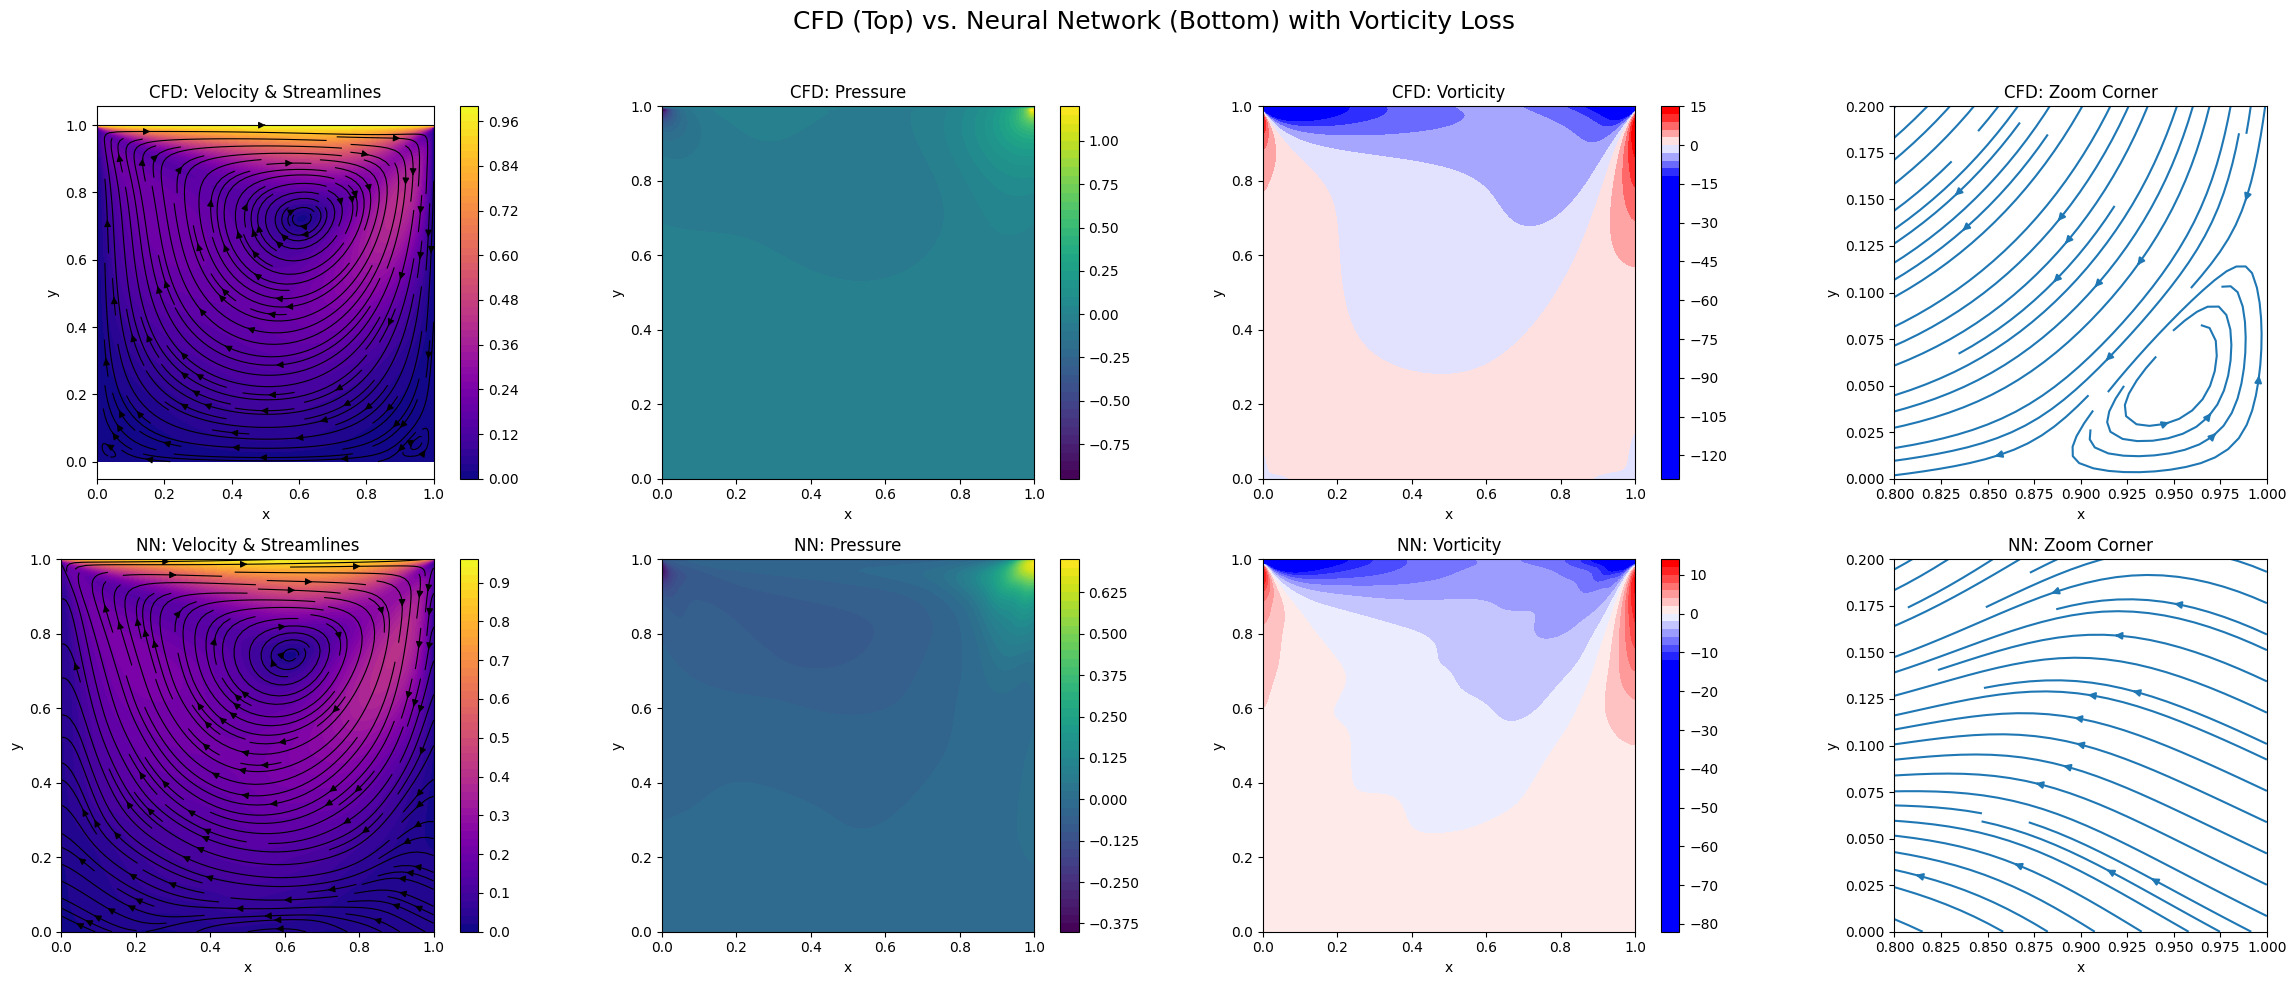

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from scipy.interpolate import griddata

# ==============================================================================
# بخش ۱: حل‌گر دینامیک سیالات محاسباتی (CFD)
# این بخش بدون تغییر باقی می‌ماند.
# ==============================================================================
def solve_cfd_cavity(nx=129, ny=129, Re=100.0, max_physical_time=20.0):
    """
    Solves the 2D Lid-Driven Cavity problem on a refined mesh.
    """
    print("--- مرحله ۱: شروع حل با استفاده از کد CFD (شبکه دقیق‌تر) ---")
    Lx, Ly = 1.0, 1.0
    dx, dy = Lx/(nx-1), Ly/(ny-1)
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X, Y = np.meshgrid(x, y)
    nu = 1.0/Re
    sigma = 0.2
    dt = sigma * min(dx**2/nu, dy**2/nu)
    print(f"CFD Grid: {nx}x{ny}, Re: {Re}, Stable dt: {dt:.6f}")
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))

    t, step = 0.0, 0
    start_time = time.time()
    nit = 50
    while t < max_physical_time:
        un, vn = u.copy(), v.copy()
        u[1:-1,1:-1] = (un[1:-1,1:-1] - dt/dx * un[1:-1,1:-1] * (un[1:-1,1:-1]-un[1:-1,0:-2])
                        - dt/dy * vn[1:-1,1:-1] * (un[1:-1,1:-1]-un[0:-2,1:-1])
                        - dt/(2*dx) * (p[1:-1,2:] - p[1:-1,0:-2])
                        + nu*dt/dx**2*(un[1:-1,2:] - 2*un[1:-1,1:-1] + un[1:-1,0:-2])
                        + nu*dt/dy**2*(un[2:,1:-1] - 2*un[1:-1,1:-1] + un[0:-2,1:-1]))
        v[1:-1,1:-1] = (vn[1:-1,1:-1] - dt/dx * un[1:-1,1:-1] * (vn[1:-1,1:-1]-vn[1:-1,0:-2])
                        - dt/dy * vn[1:-1,1:-1] * (vn[1:-1,1:-1]-vn[0:-2,1:-1])
                        - dt/(2*dy) * (p[2:,1:-1] - p[0:-2,1:-1])
                        + nu*dt/dx**2*(vn[1:-1,2:] - 2*vn[1:-1,1:-1] + vn[1:-1,0:-2])
                        + nu*dt/dy**2*(vn[2:,1:-1] - 2*vn[1:-1,1:-1] + vn[0:-2,1:-1]))
        u[0,:] = u[:,0] = u[:,-1] = 0.0
        u[-1,:] = 1.0
        v[0,:] = v[-1,:] = v[:,0] = v[:,-1] = 0.0
        rhs_p = (1/dt*((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx) + (v[2:,1:-1]-v[0:-2,1:-1])/(2*dy)))
        for _ in range(nit):
            pn = p.copy()
            p[1:-1,1:-1] = (((pn[1:-1,2:] + pn[1:-1,0:-2]) * dy**2 +
                                (pn[2:,1:-1] + pn[0:-2,1:-1]) * dx**2 -
                                rhs_p * dx**2 * dy**2) /
                                (2*(dx**2 + dy**2)))
            p[:, -1] = p[:, -2]
            p[0, :] = p[1, :]
            p[:, 0] = p[:, 1]
            p[-1, :] = 0.0
        t += dt
        step += 1
    print(f"حل CFD در {time.time() - start_time:.2f} ثانیه به پایان رسید.")
    return u, v, p, X, Y, dx, dy

# ==============================================================================
# بخش ۲: شبکه عصبی و یادگیری نظارت‌شده (float32)
# ==============================================================================
class SupervisedCavityModel:
    def __init__(self, layers=[2, 128, 128, 128, 128, 128, 3], lr=1e-3):
        # FIX: افزایش ظرفیت شبکه برای یادگیری بهتر جزئیات
        self.layers = layers
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        # FIX: ضریب وزنی برای تابع زیان ورتیسیته
        self.vorticity_weight = tf.constant(0.05, dtype=tf.float32)


    def build_model(self):
        inputs = Input(shape=(self.layers[0],), dtype='float32')
        x = inputs
        for units in self.layers[1:-1]:
            x = Dense(units, activation='tanh')(x)
        outputs = Dense(self.layers[-1], name='outputs')(x)
        return Model(inputs=inputs, outputs=outputs)

    def prepare_training_data(self, u, v, p, X, Y, dx, dy):
        """
        FIX: محاسبه ورتیسیته از داده‌های CFD و افزودن آن به داده‌های آموزشی
        """
        print("آماده‌سازی داده‌های آموزشی شامل ورتیسیته و نمونه‌برداری متمرکز...")

        # --- محاسبه ورتیسیته از داده‌های CFD ---
        # omega = dv/dx - du/dy
        v_grad_x = np.gradient(v, dx, axis=1)
        u_grad_y = np.gradient(u, dy, axis=0)
        omega = v_grad_x - u_grad_y

        # داده‌های اصلی از شبکه CFD
        X_flat = X.flatten(); Y_flat = Y.flatten()
        u_flat = u.flatten(); v_flat = v.flatten(); p_flat = p.flatten(); omega_flat = omega.flatten()
        cfd_inputs = np.vstack([X_flat, Y_flat]).T
        # خروجی اکنون شامل 4 متغیر است: u, v, p, omega
        cfd_outputs = np.vstack([u_flat, v_flat, p_flat, omega_flat]).T

        # --- ایجاد نقاط اضافی با تراکم بالا در گوشه‌های پایینی ---
        n_corners = 8000
        corner_size = 0.2
        corner_x_bl = np.random.rand(n_corners, 1) * corner_size
        corner_y_bl = np.random.rand(n_corners, 1) * corner_size
        corner_x_br = 1.0 - (np.random.rand(n_corners, 1) * corner_size)
        corner_y_br = np.random.rand(n_corners, 1) * corner_size
        biased_inputs_np = np.vstack([
            np.hstack([corner_x_bl, corner_y_bl]),
            np.hstack([corner_x_br, corner_y_br])
        ])

        # درون‌یابی برای یافتن مقادیر u,v,p,omega در نقاط جدید
        print("درون‌یابی داده‌ها (شامل ورتیسیته) برای نقاط متمرکز...")
        biased_outputs_np = griddata(cfd_inputs, cfd_outputs, biased_inputs_np, method='cubic')

        # ترکیب داده‌های اصلی و بایاس شده
        final_inputs = np.concatenate([cfd_inputs, biased_inputs_np]).astype(np.float32)
        final_outputs = np.concatenate([cfd_outputs, biased_outputs_np]).astype(np.float32)

        print(f"مجموع نقاط آموزشی: {len(final_inputs)}")
        return tf.constant(final_inputs), tf.constant(final_outputs)

    @tf.function
    def train_step(self, x_batch, y_batch):
        """
        FIX: یک گام آموزش با استفاده از تابع زیان ترکیبی (داده + ورتیسیته)
        """
        with tf.GradientTape() as tape:
            # نوار گرادیان برای محاسبه مشتقات نسبت به ورودی‌ها (x,y)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x_batch)
                y_pred = self.model(x_batch, training=True)
                u_pred, v_pred, p_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

            # محاسبه گرادیان‌های سرعت نسبت به x و y
            grad_u = tape2.gradient(u_pred, x_batch)
            grad_v = tape2.gradient(v_pred, x_batch)
            del tape2 # حذف نوار پایدار

            # ورتیسیته پیش‌بینی شده: omega = dv/dx - du/dy
            dv_dx = grad_v[:, 0]
            du_dy = grad_u[:, 1]
            omega_pred = dv_dx - du_dy

            # مقادیر واقعی از مجموعه داده
            u_true, v_true, p_true, omega_true = y_batch[:,0], y_batch[:,1], y_batch[:,2], y_batch[:,3]

            # --- تابع زیان ترکیبی ---
            loss_data = tf.reduce_mean(tf.square(u_true - u_pred)) + \
                        tf.reduce_mean(tf.square(v_true - v_pred)) + \
                        tf.reduce_mean(tf.square(p_true - p_pred))

            loss_vorticity = tf.reduce_mean(tf.square(omega_true - omega_pred))

            # ترکیب زیان‌ها با ضریب وزنی
            loss = loss_data + self.vorticity_weight * loss_vorticity

        # محاسبه گرادیان‌ها نسبت به وزن‌های شبکه و به‌روزرسانی
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, loss_data, loss_vorticity

    def train(self, cfd_data, n_epochs=15000, batch_size=4096, plot_freq=5000):
        print("\n--- مرحله ۲: شروع آموزش شبکه با تابع زیان ترکیبی (داده + ورتیسیته) ---")
        X_train, y_train = self.prepare_training_data(*cfd_data)
        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size)

        start = time.time()
        if not os.path.exists('intermediate_plots'):
            os.makedirs('intermediate_plots')

        for epoch in range(n_epochs):
            total_loss, total_loss_data, total_loss_vorticity = 0, 0, 0
            for step, (x_batch, y_batch) in enumerate(dataset):
                loss, loss_data, loss_vorticity = self.train_step(x_batch, y_batch)
                total_loss += loss
                total_loss_data += loss_data
                total_loss_vorticity += loss_vorticity

            if (epoch + 1) % 1000 == 0:
                avg_loss = total_loss / (step + 1)
                avg_loss_data = total_loss_data / (step + 1)
                avg_loss_vorticity = total_loss_vorticity / (step + 1)
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4e} "
                      f"(Data: {avg_loss_data:.4e}, Vorticity: {avg_loss_vorticity:.4e})")

            if (epoch + 1) % plot_freq == 0:
                self.plot_comparison(cfd_data, epoch=epoch + 1, save=True)

        print(f"آموزش شبکه در {time.time() - start:.2f} ثانیه به پایان رسید.")

    def plot_comparison(self, cfd_data, epoch=None, save=False):
        """
        FIX: بصری‌سازی نتایج در یک شبکه ۲x۴ شامل مقایسه ورتیسیته.
        """
        is_intermediate = epoch is not None and save
        if is_intermediate:
            print(f"\n--- مرحله میانی: رایت کردن نتایج در گام {epoch} ---")
        else:
            print("\n--- مرحله ۳: مقایسه نتایج نهایی CFD و شبکه عصبی ---")

        u_cfd, v_cfd, p_cfd, X, Y, dx, dy = cfd_data

        pts = np.hstack([X.flatten()[:,None], Y.flatten()[:,None]]).astype(np.float32)
        preds = self.model.predict(pts, verbose=0)
        u_nn = preds[:,0].reshape(X.shape)
        v_nn = preds[:,1].reshape(X.shape)
        p_nn = preds[:,2].reshape(X.shape)

        # محاسبه ورتیسیته از داده‌های CFD و NN برای مقایسه
        omega_cfd = np.gradient(v_cfd, dx, axis=1) - np.gradient(u_cfd, dy, axis=0)
        omega_nn = np.gradient(v_nn, dx, axis=1) - np.gradient(u_nn, dy, axis=0)

        fig, axes = plt.subplots(2, 4, figsize=(24, 10))
        title = 'CFD (Top) vs. Neural Network (Bottom) with Vorticity Loss'
        if is_intermediate:
            title = f'CFD (Top) vs. NN (Bottom) at Epoch {epoch}'
        fig.suptitle(title, fontsize=18)

        # --- Row 1: CFD Data ---
        speed_cfd = np.sqrt(u_cfd**2 + v_cfd**2)
        cf1 = axes[0, 0].contourf(X, Y, speed_cfd, levels=50, cmap='plasma'); axes[0, 0].streamplot(X, Y, u_cfd, v_cfd, density=1.5, color='k', linewidth=0.8); axes[0, 0].set_title('CFD: Velocity & Streamlines'); fig.colorbar(cf1, ax=axes[0, 0])
        cf2 = axes[0, 1].contourf(X, Y, p_cfd, levels=50, cmap='viridis'); axes[0, 1].set_title('CFD: Pressure'); fig.colorbar(cf2, ax=axes[0, 1])
        # FIX: نمودار ورتیسیته برای CFD
        vort_max = np.abs(omega_cfd).max() * 0.1 # محدود کردن رنگ برای وضوح بهتر
        cf3 = axes[0, 2].contourf(X, Y, omega_cfd, levels=50, cmap='bwr', vmin=-vort_max, vmax=vort_max); axes[0, 2].set_title('CFD: Vorticity'); fig.colorbar(cf3, ax=axes[0, 2])
        axes[0, 3].streamplot(X, Y, u_cfd, v_cfd, density=4); axes[0, 3].set_title('CFD: Zoom Corner'); axes[0, 3].set_xlim(0.8, 1.0); axes[0, 3].set_ylim(0.0, 0.2)

        # --- Row 2: Neural Network Data ---
        speed_nn = np.sqrt(u_nn**2 + v_nn**2)
        cf4 = axes[1, 0].contourf(X, Y, speed_nn,  levels=50, cmap='plasma'); axes[1, 0].streamplot(X, Y, u_nn, v_nn, density=1.5, color='k', linewidth=0.8); axes[1, 0].set_title('NN: Velocity & Streamlines'); fig.colorbar(cf4, ax=axes[1, 0])
        cf5 = axes[1, 1].contourf(X, Y, p_nn, levels=50, cmap='viridis'); axes[1, 1].set_title('NN: Pressure'); fig.colorbar(cf5, ax=axes[1, 1])
        # FIX: نمودار ورتیسیته برای NN
        cf6 = axes[1, 2].contourf(X, Y, omega_nn, levels=50, cmap='bwr', vmin=-vort_max, vmax=vort_max); axes[1, 2].set_title('NN: Vorticity'); fig.colorbar(cf6, ax=axes[1, 2])
        axes[1, 3].streamplot(X, Y, u_nn, v_nn, density=4); axes[1, 3].set_title('NN: Zoom Corner'); axes[1, 3].set_xlim(0.8, 1.0); axes[1, 3].set_ylim(0.0, 0.2)

        for i in range(2):
            for j in range(4):
                axes[i, j].set_xlabel('x'); axes[i, j].set_ylabel('y'); axes[i,j].set_aspect('equal')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        if is_intermediate:
            save_path = f'intermediate_plots/comparison_epoch_{epoch:05d}.png'
            plt.savefig(save_path, dpi=200)
            print(f"نمودار میانی در مسیر '{save_path}' ذخیره شد.")
            plt.close(fig)
        else:
            plt.show()

# ==============================================================================
# بخش ۳: اجرای اصلی
# ==============================================================================
if __name__ == '__main__':
    # حلگر CFD را اجرا کرده و dx, dy را نیز برمی‌گردانیم
    u_data, v_data, p_data, X_grid, Y_grid, dx_val, dy_val = solve_cfd_cavity(nx=129, ny=129, Re=100.0)
    cfd_results_ext = (u_data, v_data, p_data, X_grid, Y_grid, dx_val, dy_val)

    # مدل را با معماری کمی عمیق‌تر/عریض‌تر می‌سازیم
    model = SupervisedCavityModel(layers=[2, 128, 128, 128, 128, 128, 3])

    # آموزش با داده‌های کامل و تابع زیان جدید
    model.train(cfd_data=cfd_results_ext, n_epochs=20000, plot_freq=5000, batch_size=4096)

    # نمایش نتیجه نهایی
    model.plot_comparison(cfd_data=cfd_results_ext)

--- شروع اجرای کامل با شبکه دقیق CFD ---
توجه: این فرآیند بسیار زمان‌بر است. لطفاً صبور باشید.
--- مرحله ۱: شروع حل با استفاده از کد CFD (شبکه 129x129) ---
CFD Grid: 129x129, Re: 100.0, Stable dt: 0.001221
حل CFD در 169.77 ثانیه به پایان رسید.

--- مرحله ۲: شروع آموزش شبکه با داده‌های پاک‌سازی و نرمال‌شده ---
آماده‌سازی داده‌های آموزشی شامل ورتیسیته و نمونه‌برداری متمرکز...
درون‌یابی داده‌ها برای نقاط متمرکز...
0 نقطه به دلیل مقادیر NaN حذف شد.
داده‌های خروجی (u,v,p,omega) نرمال‌سازی شدند.
مجموع نقاط آموزشی: 32641
Epoch 1/20000, Loss: 3.5025e-01 (Data: 3.5008e-01, Vorticity: 1.7007e-03)
Epoch 1000/20000, Loss: 6.6707e-04 (Data: 6.5481e-04, Vorticity: 1.2253e-04)
Epoch 2000/20000, Loss: 1.7115e-03 (Data: 1.6964e-03, Vorticity: 1.5071e-04)
Epoch 3000/20000, Loss: 6.4145e-05 (Data: 6.2594e-05, Vorticity: 1.5512e-05)
Epoch 4000/20000, Loss: 3.5945e-04 (Data: 3.4720e-04, Vorticity: 1.2252e-04)
Epoch 5000/20000, Loss: 2.6161e-05 (Data: 2.4407e-05, Vorticity: 1.7535e-05)

--- مرحله میانی: رای

FileNotFoundError: [Errno 2] No such file or directory: 'intermediate_plots/comparison_epoch_05000.png'

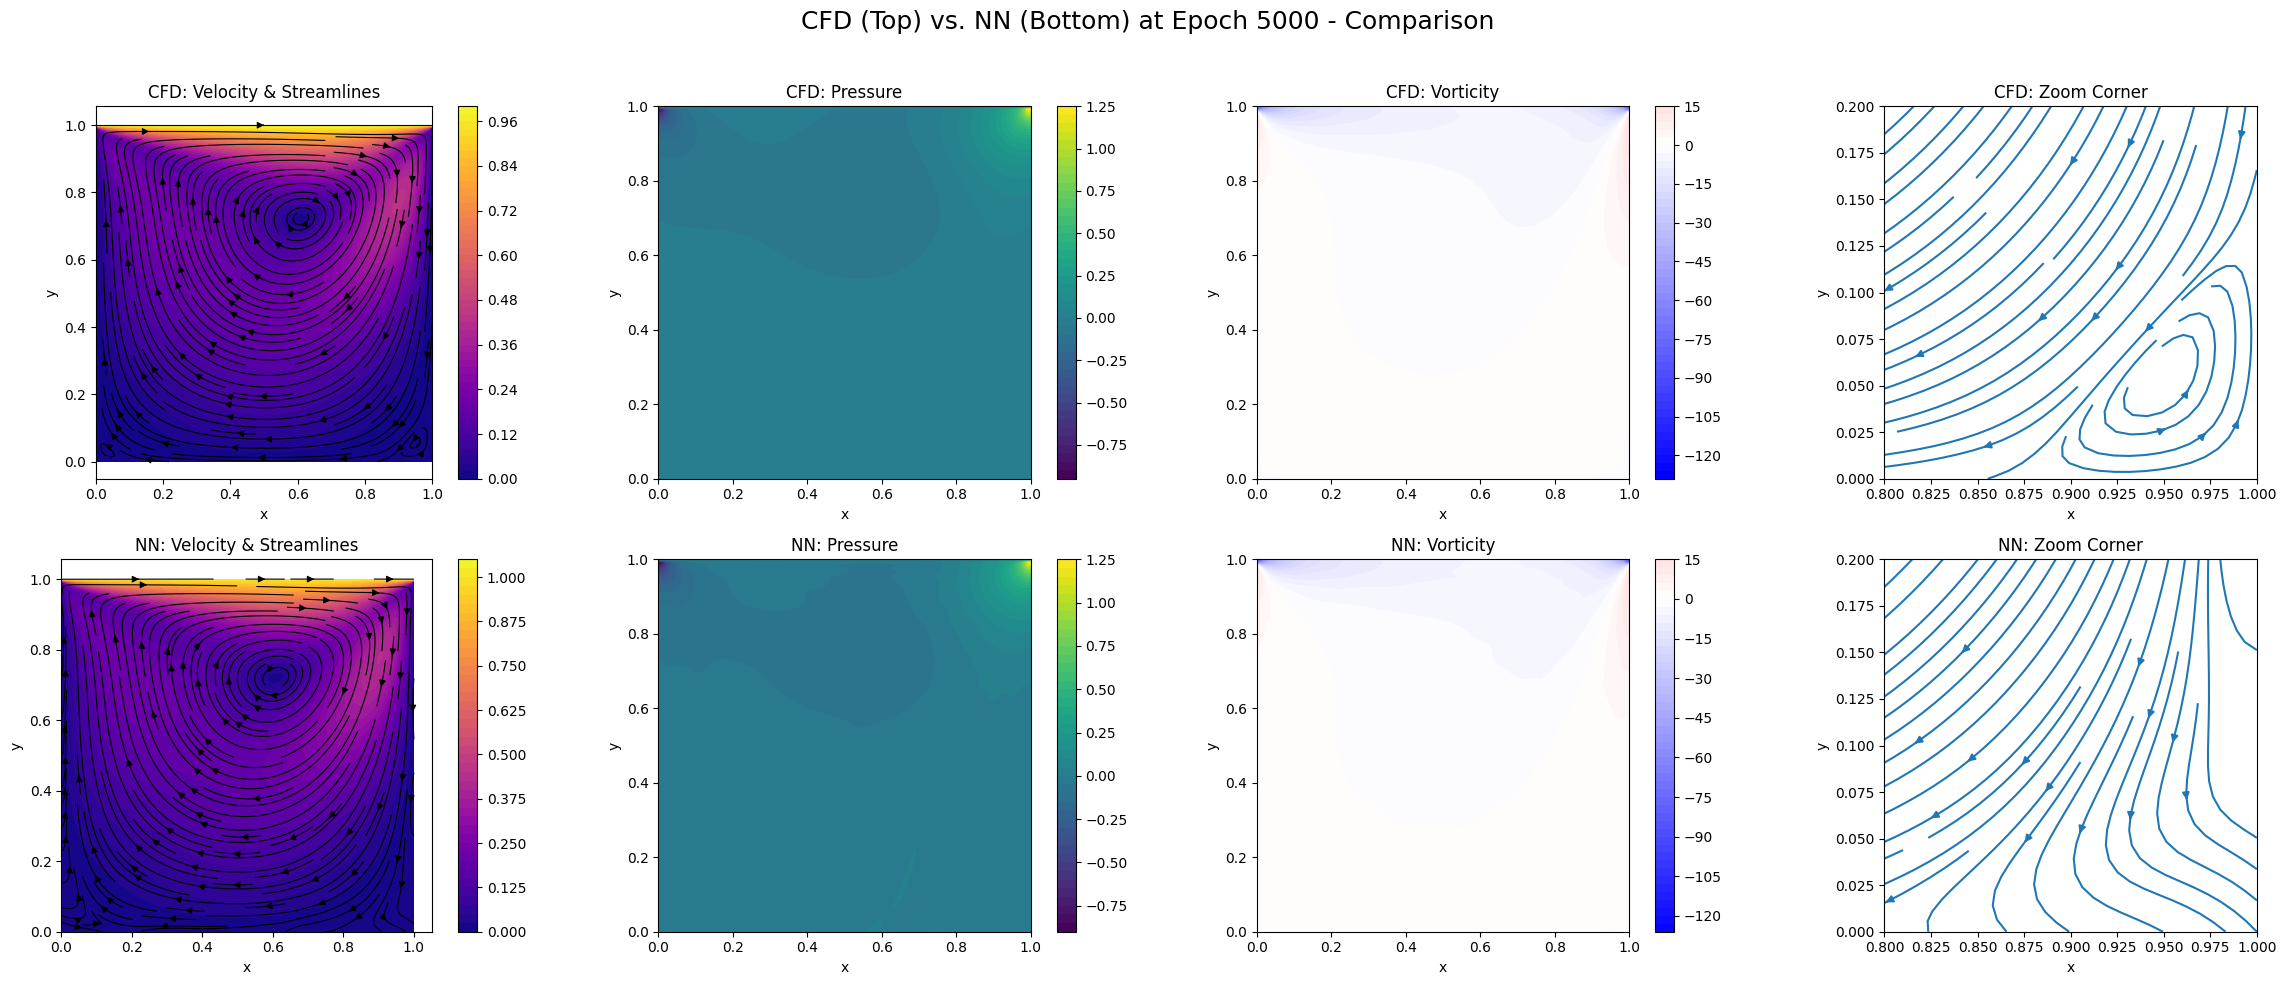

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from scipy.interpolate import griddata

# ==============================================================================
# بخش ۱: حل‌گر دینامیک سیالات محاسباتی (CFD)
# ==============================================================================
def solve_cfd_cavity(nx=129, ny=129, Re=100.0, max_physical_time=20.0):
    """
    Solves the 2D Lid-Driven Cavity problem on a refined mesh.
    """
    print(f"--- مرحله ۱: شروع حل با استفاده از کد CFD (شبکه {nx}x{ny}) ---")
    Lx, Ly = 1.0, 1.0
    dx, dy = Lx/(nx-1), Ly/(ny-1)
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X, Y = np.meshgrid(x, y)
    nu = 1.0/Re
    sigma = 0.2
    dt = sigma * min(dx**2/nu, dy**2/nu)
    print(f"CFD Grid: {nx}x{ny}, Re: {Re}, Stable dt: {dt:.6f}")
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))

    t, step = 0.0, 0
    start_time = time.time()
    nit = 50
    while t < max_physical_time:
        un, vn = u.copy(), v.copy()
        b = np.zeros((ny, nx))
        b[1:-1,1:-1] = (1/dt*
                    ((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx)+(v[2:,1:-1]-v[0:-2,1:-1])/(2*dy)) -
                    ((u[1:-1,2:]-u[1:-1,0:-2])/(2*dx))**2 -
                    2*(u[2:,1:-1]-u[0:-2,1:-1])/(2*dy)*(v[1:-1,2:]-v[1:-1,0:-2])/(2*dx) -
                    ((v[2:,1:-1]-v[0:-2,1:-1])/(2*dy))**2)

        for _ in range(nit):
            pn = p.copy()
            p[1:-1,1:-1] = (((pn[1:-1,2:]+pn[1:-1,0:-2])*dy**2+(pn[2:,1:-1]+pn[0:-2,1:-1])*dx**2)
                         /(2*(dx**2+dy**2)) -
                         dx**2*dy**2/(2*(dx**2+dy**2))*b[1:-1,1:-1])

            p[:, -1] = p[:, -2]
            p[0, :] = p[1, :]
            p[:, 0] = p[:, 1]
            p[-1, :] = 0.0

        u[1:-1,1:-1] = (un[1:-1,1:-1]-
                     un[1:-1,1:-1]*dt/dx*(un[1:-1,1:-1]-un[1:-1,0:-2])-
                     vn[1:-1,1:-1]*dt/dy*(un[1:-1,1:-1]-un[0:-2,1:-1])-
                     dt/(2*dx)*(p[1:-1,2:]-p[1:-1,0:-2])+
                     nu*(dt/dx**2*(un[1:-1,2:]-2*un[1:-1,1:-1]+un[1:-1,0:-2])+
                         dt/dy**2*(un[2:,1:-1]-2*un[1:-1,1:-1]+un[0:-2,1:-1])))

        v[1:-1,1:-1] = (vn[1:-1,1:-1]-
                     un[1:-1,1:-1]*dt/dx*(vn[1:-1,1:-1]-vn[1:-1,0:-2])-
                     vn[1:-1,1:-1]*dt/dy*(vn[1:-1,1:-1]-vn[0:-2,1:-1])-
                     dt/(2*dy)*(p[2:,1:-1]-p[0:-2,1:-1])+
                     nu*(dt/dx**2*(vn[1:-1,2:]-2*vn[1:-1,1:-1]+vn[1:-1,0:-2])+
                         dt/dy**2*(vn[2:,1:-1]-2*vn[1:-1,1:-1]+vn[0:-2,1:-1])))

        u[0,:] = 0; u[:,0] = 0; u[:,-1] = 0; u[-1,:] = 1
        v[0,:] = 0; v[-1,:] = 0; v[:,0] = 0; v[:,-1] = 0
        t += dt
        step += 1
    print(f"حل CFD در {time.time() - start_time:.2f} ثانیه به پایان رسید.")
    return u, v, p, X, Y, dx, dy

# ==============================================================================
# بخش ۲: شبکه عصبی و یادگیری نظارت‌شده (نسخه نهایی و اصلاح‌شده)
# ==============================================================================
class SupervisedCavityModel:
    def __init__(self, layers=[2, 128, 128, 128, 128, 128, 3], lr=1e-3):
        self.layers = layers
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.vorticity_weight = tf.constant(0.1, dtype=tf.float32)
        self.output_scalers = None

    def build_model(self):
        inputs = Input(shape=(self.layers[0],), dtype='float32')
        x = inputs
        for units in self.layers[1:-1]:
            x = Dense(units, activation='tanh')(x)
        outputs = Dense(self.layers[-1], name='outputs')(x)
        return Model(inputs=inputs, outputs=outputs)

    def prepare_training_data(self, u, v, p, X, Y, dx, dy):
        print("آماده‌سازی داده‌های آموزشی شامل ورتیسیته و نمونه‌برداری متمرکز...")
        v_grad_x = np.gradient(v, dx, axis=1)
        u_grad_y = np.gradient(u, dy, axis=0)
        omega = v_grad_x - u_grad_y

        X_flat = X.flatten(); Y_flat = Y.flatten()
        u_flat = u.flatten(); v_flat = v.flatten(); p_flat = p.flatten(); omega_flat = omega.flatten()
        cfd_inputs = np.vstack([X_flat, Y_flat]).T
        cfd_outputs = np.vstack([u_flat, v_flat, p_flat, omega_flat]).T

        n_corners = 8000
        corner_size = 0.2
        corner_x_bl = np.random.rand(n_corners, 1) * corner_size
        corner_y_bl = np.random.rand(n_corners, 1) * corner_size
        corner_x_br = 1.0 - (np.random.rand(n_corners, 1) * corner_size)
        corner_y_br = np.random.rand(n_corners, 1) * corner_size
        biased_inputs_np = np.vstack([np.hstack([corner_x_bl, corner_y_bl]), np.hstack([corner_x_br, corner_y_br])])

        print("درون‌یابی داده‌ها برای نقاط متمرکز...")
        biased_outputs_np = griddata(cfd_inputs, cfd_outputs, biased_inputs_np, method='cubic')

        nan_mask = ~np.isnan(biased_outputs_np).any(axis=1)
        biased_inputs_np = biased_inputs_np[nan_mask]
        biased_outputs_np = biased_outputs_np[nan_mask]
        print(f"{np.sum(~nan_mask)} نقطه به دلیل مقادیر NaN حذف شد.")

        final_inputs = np.concatenate([cfd_inputs, biased_inputs_np]).astype(np.float32)
        final_outputs_raw = np.concatenate([cfd_outputs, biased_outputs_np]).astype(np.float32)

        min_vals_np = np.min(final_outputs_raw, axis=0)
        max_vals_np = np.max(final_outputs_raw, axis=0)

        self.output_scalers = {
            'min': tf.constant(min_vals_np, dtype=tf.float32),
            'max': tf.constant(max_vals_np, dtype=tf.float32)
        }

        final_outputs_normalized = 2.0 * (final_outputs_raw - min_vals_np) / (max_vals_np - min_vals_np) - 1.0
        print("داده‌های خروجی (u,v,p,omega) نرمال‌سازی شدند.")

        print(f"مجموع نقاط آموزشی: {len(final_inputs)}")
        return tf.constant(final_inputs), tf.constant(final_outputs_normalized)

    @tf.function
    def train_step(self, x_batch, y_batch_normalized):
        with tf.GradientTape() as tape:
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x_batch)

                y_pred_normalized = self.model(x_batch, training=True)

                min_vals = self.output_scalers['min']
                max_vals = self.output_scalers['max']
                y_pred = (y_pred_normalized + 1.0) / 2.0 * (max_vals[0:3] - min_vals[0:3]) + min_vals[0:3]

                u_pred, v_pred = y_pred[:, 0], y_pred[:, 1]

            grad_u = tape2.gradient(u_pred, x_batch)
            grad_v = tape2.gradient(v_pred, x_batch)
            del tape2

            dv_dx = grad_v[:, 0]
            du_dy = grad_u[:, 1]
            omega_pred = dv_dx - du_dy

            omega_pred_normalized = 2.0 * (omega_pred - self.output_scalers['min'][3]) / (self.output_scalers['max'][3] - self.output_scalers['min'][3]) - 1.0

            u_true_norm, v_true_norm, p_true_norm, omega_true_norm = y_batch_normalized[:,0], y_batch_normalized[:,1], y_batch_normalized[:,2], y_batch_normalized[:,3]
            u_pred_norm, v_pred_norm, p_pred_norm = y_pred_normalized[:,0], y_pred_normalized[:,1], y_pred_normalized[:,2]

            loss_data = tf.reduce_mean(tf.square(u_true_norm - u_pred_norm)) + \
                        tf.reduce_mean(tf.square(v_true_norm - v_pred_norm)) + \
                        tf.reduce_mean(tf.square(p_true_norm - p_pred_norm))

            loss_vorticity = tf.reduce_mean(tf.square(omega_true_norm - omega_pred_normalized))

            loss = loss_data + self.vorticity_weight * loss_vorticity

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, loss_data, loss_vorticity

    def train(self, cfd_data, n_epochs=15000, batch_size=4096, plot_freq=5000):
        print("\n--- مرحله ۲: شروع آموزش شبکه با داده‌های پاک‌سازی و نرمال‌شده ---")
        X_train, y_train_normalized = self.prepare_training_data(*cfd_data)
        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_normalized)).shuffle(len(X_train)).batch(batch_size)

        start = time.time()
        if not os.path.exists('intermediate_plots'):
            os.makedirs('intermediate_plots')

        for epoch in range(n_epochs):
            total_loss, total_loss_data, total_loss_vorticity = 0, 0, 0
            for step, (x_batch, y_batch) in enumerate(dataset):
                loss, loss_data, loss_vorticity = self.train_step(x_batch, y_batch)
                total_loss += loss
                total_loss_data += loss_data
                total_loss_vorticity += loss_vorticity

            if (epoch + 1) % 1000 == 0 or epoch == 0:
                avg_loss = total_loss / (step + 1)
                avg_loss_data = total_loss_data / (step + 1)
                avg_loss_vorticity = total_loss_vorticity / (step + 1)
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4e} "
                      f"(Data: {avg_loss_data:.4e}, Vorticity: {avg_loss_vorticity:.4e})")

            if (epoch + 1) % plot_freq == 0:
                self.plot_comparison(cfd_data, epoch=epoch + 1, save=True)

        print(f"آموزش شبکه در {time.time() - start:.2f} ثانیه به پایان رسید.")

    def plot_comparison(self, cfd_data, epoch=None, save=False):
        is_intermediate = epoch is not None and save
        if is_intermediate:
            print(f"\n--- مرحله میانی: رایت کردن نتایج در گام {epoch} ---")
        else:
            print("\n--- مرحله ۳: مقایسه نتایج نهایی CFD و شبکه عصبی ---")

        u_cfd, v_cfd, p_cfd, X, Y, dx, dy = cfd_data
        pts = np.hstack([X.flatten()[:,None], Y.flatten()[:,None]]).astype(np.float32)

        preds_normalized = self.model.predict(pts, verbose=0)

        min_vals = self.output_scalers['min'].numpy()
        max_vals = self.output_scalers['max'].numpy()
        preds = (preds_normalized + 1.0) / 2.0 * (max_vals[0:3] - min_vals[0:3]) + min_vals[0:3]

        u_nn = preds[:,0].reshape(X.shape)
        v_nn = preds[:,1].reshape(X.shape)
        p_nn = preds[:,2].reshape(X.shape)

        omega_cfd = np.gradient(v_cfd, dx, axis=1) - np.gradient(u_cfd, dy, axis=0)
        omega_nn = np.gradient(v_nn, dx, axis=1) - np.gradient(u_nn, dy, axis=0)

        fig, axes = plt.subplots(2, 4, figsize=(24, 10))
        title = 'CFD (Top) vs. Neural Network (Bottom) - Comparison'
        if is_intermediate:
            title = f'CFD (Top) vs. NN (Bottom) at Epoch {epoch} - Comparison'
        fig.suptitle(title, fontsize=18)

        # --- Row 1: CFD Data ---
        speed_cfd = np.sqrt(u_cfd**2 + v_cfd**2)
        cf1 = axes[0, 0].contourf(X, Y, speed_cfd, levels=50, cmap='plasma'); axes[0, 0].streamplot(X, Y, u_cfd, v_cfd, density=1.5, color='k', linewidth=0.8); axes[0, 0].set_title('CFD: Velocity & Streamlines'); fig.colorbar(cf1, ax=axes[0, 0])
        cf2 = axes[0, 1].contourf(X, Y, p_cfd, levels=50, cmap='viridis'); axes[0, 1].set_title('CFD: Pressure'); fig.colorbar(cf2, ax=axes[0, 1])
        vort_max_abs = np.abs(omega_cfd).max()
        cf3 = axes[0, 2].contourf(X, Y, omega_cfd, levels=50, cmap='bwr', vmin=-vort_max_abs, vmax=vort_max_abs); axes[0, 2].set_title('CFD: Vorticity'); fig.colorbar(cf3, ax=axes[0, 2])
        axes[0, 3].streamplot(X, Y, u_cfd, v_cfd, density=4); axes[0, 3].set_title('CFD: Zoom Corner'); axes[0, 3].set_xlim(0.8, 1.0); axes[0, 3].set_ylim(0.0, 0.2)

        # --- Row 2: Neural Network Data ---
        speed_nn = np.sqrt(u_nn**2 + v_nn**2)
        cf4 = axes[1, 0].contourf(X, Y, speed_nn, levels=50, cmap='plasma'); axes[1, 0].streamplot(X, Y, u_nn, v_nn, density=1.5, color='k', linewidth=0.8); axes[1, 0].set_title('NN: Velocity & Streamlines'); fig.colorbar(cf4, ax=axes[1, 0])
        cf5 = axes[1, 1].contourf(X, Y, p_nn, levels=50, cmap='viridis'); axes[1, 1].set_title('NN: Pressure'); fig.colorbar(cf5, ax=axes[1, 1])
        cf6 = axes[1, 2].contourf(X, Y, omega_nn, levels=50, cmap='bwr', vmin=-vort_max_abs, vmax=vort_max_abs); axes[1, 2].set_title('NN: Vorticity'); fig.colorbar(cf6, ax=axes[1, 2])
        axes[1, 3].streamplot(X, Y, u_nn, v_nn, density=4); axes[1, 3].set_title('NN: Zoom Corner'); axes[1, 3].set_xlim(0.8, 1.0); axes[1, 3].set_ylim(0.0, 0.2)

        for i in range(2):
            for j in range(4):
                axes[i, j].set_xlabel('x'); axes[i, j].set_ylabel('y'); axes[i,j].set_aspect('equal')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        if is_intermediate:
            save_path = f'intermediate_plots/comparison_epoch_{epoch:05d}.png'
            plt.savefig(save_path, dpi=200)
            print(f"نمودار میانی در مسیر '{save_path}' ذخیره شد.")
            plt.close(fig)
        else:
            plt.show()

# ==============================================================================
# بخش ۳: اجرای اصلی (نسخه کامل با شبکه دقیق)
# ==============================================================================
if __name__ == '__main__':
    print("--- شروع اجرای کامل با شبکه دقیق CFD ---")
    print("توجه: این فرآیند بسیار زمان‌بر است. لطفاً صبور باشید.")

    # ۱. حل مسئله با شبکه دقیق CFD برای تولید داده‌های باکیفیت
    u_data, v_data, p_data, X_grid, Y_grid, dx_val, dy_val = solve_cfd_cavity(
        nx=129, ny=129,         # شبکه دقیق و ریز
        Re=100.0,
        max_physical_time=20.0  # زمان کافی برای رسیدن به پایداری
    )
    cfd_results_ext = (u_data, v_data, p_data, X_grid, Y_grid, dx_val, dy_val)

    # ۲. ساخت مدل کامل شبکه عصبی
    model = SupervisedCavityModel(layers=[2, 128, 128, 128, 128, 128, 3])

    # ۳. آموزش شبکه برای تعداد ایپاک کافی تا همگرایی
    model.train(
        cfd_data=cfd_results_ext,
        n_epochs=20000,         # تعداد ایپاک بالا برای آموزش کامل
        plot_freq=5000,         # گزارش‌دهی در فواصل زمانی مناسب
        batch_size=4096         # بچ سایز مناسب برای مجموعه داده بزرگ
    )

    # ۴. نمایش نتیجه نهایی و مقایسه دقیق
    print("\n--- نمایش نتیجه نهایی و مقایسه دقیق ---")
    model.plot_comparison(cfd_data=cfd_results_ext)

    print("\n--- اجرای کامل با موفقیت به پایان رسید ---")